In [60]:
import csv
import math
import heapq
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [61]:
# Load cities from csv
cities = {}
with open('filtered_cities.csv', 'r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        city_ascii = row['city_ascii']
        lat = float(row['lat'])
        lng = float(row['lng'])
        cities[city_ascii] = (lat, lng)

In [62]:
#Distance finder function
def haversine(coord1, coord2):
    R = 6371
    dlat = math.radians(coord2[0] - coord1[0])
    dlon = math.radians(coord2[1] - coord1[1])
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(coord1[0])) * math.cos(math.radians(coord2[0])) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    distance = R * c
    return distance

In [63]:
def add_coords(start, end, cities_dict):
    
    # Checks if start is not a string
    if not isinstance(start, str):
        cities_dict["START"] = start
        print(cities_dict["START"])

    # Checks if end is not a string
    if not isinstance(end, str):
        cities_dict["END"] = end
        print(cities_dict["END"])

    return cities_dict

In [64]:
def check_loc_coord(start, end):
    if not isinstance(start, str):
        return True

In [65]:
def a_star_search(start_city, end_city, cities_dict, distance_threshold=1000):
          
    # Lookup city coordinates directly from the dictionary
    start_coords = cities_dict[start_city]
    end_coords = cities_dict[end_city]
    
    open_set = [(0, start_coords)]
    came_from = {}
    g_score = {coord: float('inf') for coord in cities_dict.values()}
    g_score[start_coords] = 0
    f_score = {coord: float('inf') for coord in cities_dict.values()}
    f_score[start_coords] = haversine(start_coords, end_coords)

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == end_coords:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(current)
            return path[::-1]

        for neighbor in cities_dict.values():
            dist = haversine(current, neighbor)
            if dist > distance_threshold:
                continue

            tentative_g_score = g_score[current] + dist
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = tentative_g_score + haversine(neighbor, end_coords)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))

    return []


In [66]:
def compute_total_distance(path):
    # Computes total distance of the path
    return sum(haversine(path[i], path[i+1]) for i in range(len(path)-1))

In [67]:
def find_point_on_path(path, percentage):
    # Finds location of percentage point given 
    total_distance = compute_total_distance(path)
    target_distance = total_distance * percentage / 100.0
    
    accumulated_distance = 0.0
    for i in range(len(path) - 1):
        segment_distance = haversine(path[i], path[i+1])
        if accumulated_distance + segment_distance >= target_distance:
            # Interpolate between path[i] and path[i+1] to get the desired point
            fraction = (target_distance - accumulated_distance) / segment_distance
            lat = path[i][0] + fraction * (path[i+1][0] - path[i][0])
            lng = path[i][1] + fraction * (path[i+1][1] - path[i][1])
            return (lat, lng)
        accumulated_distance += segment_distance

(58.51888, -113.271)
(-39.006756, 175.470045)


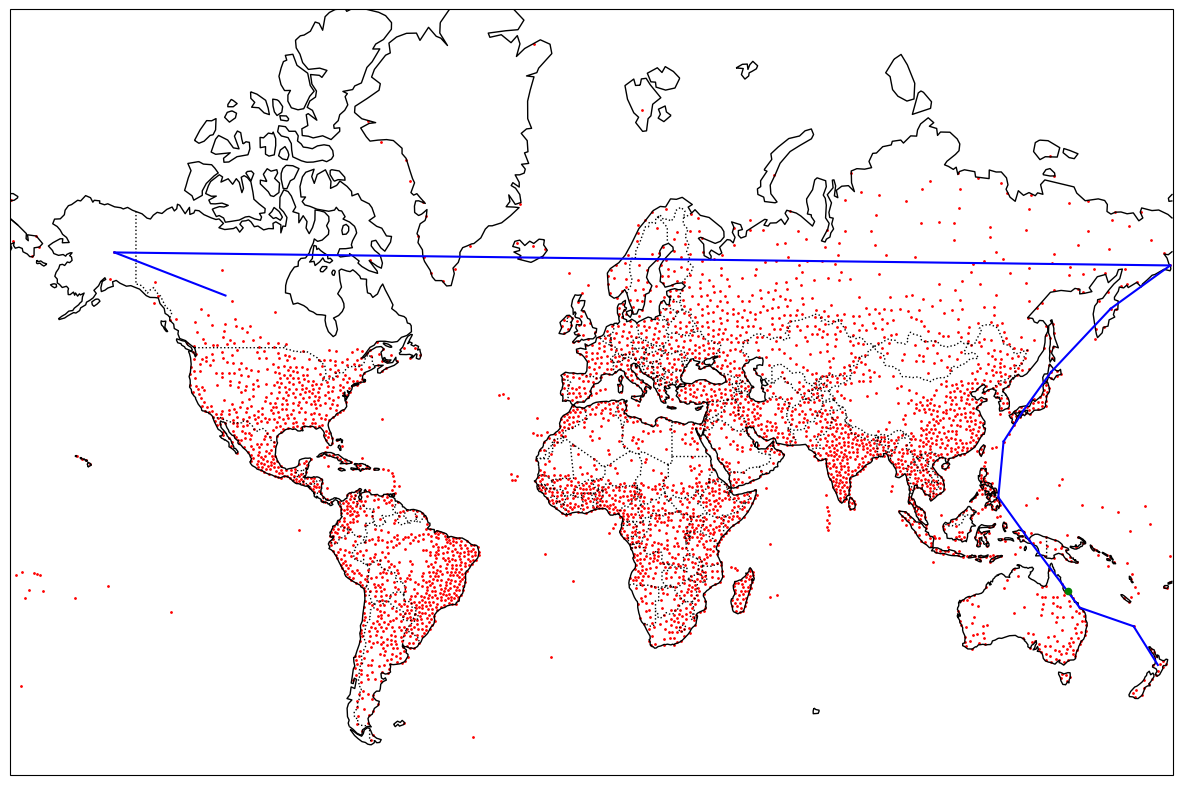

In [68]:
#Size
plt.figure(figsize=(15, 12))
#Type
ax = plt.axes(projection=ccrs.Mercator())
#Add features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
#Draw cities in CSV
ax.scatter([lng for _, (lat, lng) in cities.items()], [lat for _, (lat, lng) in cities.items()], color="red", s=1, transform=ccrs.PlateCarree())

start = (58.51888, -113.271)
end = (-39.0067560, 175.470045) 

#start = "Tatarsk"
#end = "Lima"

# Check if start and end are coords
if check_loc_coord:
    cities_dict = add_coords(start, end, cities)
    path = a_star_search("START", "END", cities_dict, distance_threshold=2000)

# Else run A* with city names
else:
    path = a_star_search(start, end, cities, distance_threshold=2000)

for i in range(len(path)-1):
    ax.plot([path[i][1], path[i+1][1]], [path[i][0], path[i+1][0]], color='blue', transform=ccrs.PlateCarree())


# Percentage travelled output
percentage = 80
point_on_path = find_point_on_path(path, percentage)

ax.scatter(point_on_path[1], point_on_path[0], color="green", s=20, alpha=1, zorder=3, transform=ccrs.PlateCarree())

plt.show()
